# Experiment 07: Attention U-Net with Cyclical Learning Rate (CLR)

This notebook addresses the training instability observed in previous experiments. We will use a Cyclical Learning Rate (CLR) schedule instead of a constant learning rate. The goal is to help the optimizer escape poor local minima and find a more robust solution.

### **Methodology**

This is a two-part experiment:
1.  **LR Range Test**: We first run a short training process where we linearly increase the learning rate from a very small to a large value. We plot the loss vs. the learning rate to identify the optimal range where the loss decreases most rapidly.
2.  **Full Training**: We use the identified optimal range to train our full model for 50 epochs using a CLR scheduler.

### **Model Configuration**

*   **Objective**: Stabilize training and improve performance using a CLR schedule.
*   **Model Architecture**: Attention U-Net.
*   **Dataset**: D2_TCPW, eligible patients.
*   **Preprocessing**: RAovSeg custom preprocessing.
*   **Loss Function**: Focal Tversky Loss.
*   **Optimizer**: Adam.
*   **Learning Rate**: **Cyclical, varying between a min and max bound.**
*   **Epochs**: 50.
*   **Batch Size**: 16.

--- Loading Data for LR Range Test ---
Loading manifest from ../data/d2_manifest_t2fs_ovary_eligible.csv and creating slice map...
Slice map created. Found 278 slices containing the ovary.

Using device: cuda


LR Range Test: 100%|██████████| 100/100 [20:59<00:00, 12.59s/it]


Plotting LR Range Test Results...


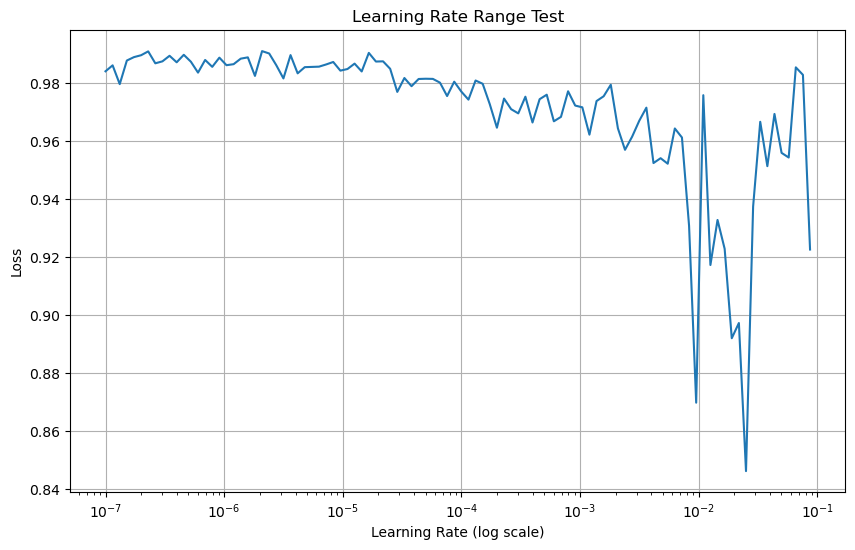

In [2]:
# --- Imports and Setup ---
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import numpy as np

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_loader import UterusDatasetWithPreprocessing 
from src.models import AttentionUNet
from src.losses import FocalTverskyLoss

# --- Configuration for LR Range Test ---
manifest_path = '../data/d2_manifest_t2fs_ovary_eligible.csv'
image_size = 256
batch_size = 16
start_lr = 1e-7
end_lr = 1e-1
num_steps = 100 # Number of steps to increase the LR

# --- Data Loading ---
print("--- Loading Data for LR Range Test ---")
# Only need the training data for this test
train_full_dataset = UterusDatasetWithPreprocessing(manifest_path=manifest_path, image_size=image_size, augment=True)
patient_ids = train_full_dataset.manifest['patient_id'].unique()
split_idx = int(len(patient_ids) * 0.8)
train_ids = patient_ids[:split_idx]
train_indices = [i for i, sm in enumerate(train_full_dataset.slice_map) if train_full_dataset.manifest.loc[sm['patient_index'], 'patient_id'] in train_ids]
train_dataset = Subset(train_full_dataset, train_indices)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# --- LR Range Test Logic ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

model = AttentionUNet(n_channels=1, n_classes=1).to(device)
optimizer = Adam(model.parameters(), lr=start_lr) # Start with a very small LR
criterion = FocalTverskyLoss(alpha=0.7, beta=0.3, gamma=4/3)

# Linearly increase LR from start_lr to end_lr over num_steps
lr_lambda = lambda step: (end_lr / start_lr) ** (step / num_steps)
scheduler = LambdaLR(optimizer, lr_lambda)

learning_rates = []
losses = []

model.train()
iterator = iter(train_loader)
for step in tqdm(range(num_steps), desc="LR Range Test"):
    try:
        images, masks = next(iterator)
    except StopIteration:
        iterator = iter(train_loader)
        images, masks = next(iterator)

    images, masks = images.to(device), masks.to(device)
    
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, masks)
    
    # Break if loss explodes
    if torch.isnan(loss) or loss > 4 * min(losses, default=1.0):
        print("Loss exploded, stopping test.")
        break
        
    loss.backward()
    optimizer.step()
    
    learning_rates.append(scheduler.get_last_lr()[0])
    losses.append(loss.item())
    
    scheduler.step()

# --- Plot the Results ---
print("Plotting LR Range Test Results...")
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, losses)
plt.xscale("log")
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("Loss")
plt.title("Learning Rate Range Test")
plt.grid(True)
plt.show()

In [ ]:
# --- Imports for the full training run ---
from torch.optim.lr_scheduler import CyclicLR
# --- ADDED Imports that were missing ---
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import numpy as np

# --- Imports and Setup ---
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import numpy as np

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_loader import UterusDatasetWithPreprocessing 
from src.models import AttentionUNet
from src.losses import FocalTverskyLoss

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_loader import UterusDatasetWithPreprocessing 
from src.models import AttentionUNet
from src.losses import FocalTverskyLoss
# ------------------------------------

# --- Configuration for Full Training ---
base_lr = 1e-3
max_lr = 1e-2
num_epochs = 50
batch_size = 16
image_size = 256
manifest_path = '../data/d2_manifest_t2fs_ovary_eligible.csv' # <-- ADDED manifest path here

# --- Data Loading (Now self-contained) ---
print("--- Loading Data for Full Training Run ---")
# --- ADDED data loading back into this cell ---
train_full_dataset = UterusDatasetWithPreprocessing(manifest_path=manifest_path, image_size=image_size, augment=True)
val_full_dataset = UterusDatasetWithPreprocessing(manifest_path=manifest_path, image_size=image_size, augment=False)
# -------------------------------------------
patient_ids = val_full_dataset.manifest['patient_id'].unique()
split_idx = int(len(patient_ids) * 0.8)
train_ids, val_ids = patient_ids[:split_idx], patient_ids[split_idx:]
train_indices = [i for i, sm in enumerate(val_full_dataset.slice_map) if val_full_dataset.manifest.loc[sm['patient_index'], 'patient_id'] in train_ids]
val_indices = [i for i, sm in enumerate(val_full_dataset.slice_map) if val_full_dataset.manifest.loc[sm['patient_index'], 'patient_id'] in val_ids]

train_dataset = Subset(train_full_dataset, train_indices)
val_dataset = Subset(val_full_dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
print(f"Data successfully split:\nTraining samples: {len(train_dataset)}\nValidation samples: {len(val_dataset)}")


# --- Re-initialize Model and Optimizer ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # <-- ADDED device definition
model = AttentionUNet(n_channels=1, n_classes=1).to(device)
optimizer = Adam(model.parameters(), lr=base_lr)
criterion = FocalTverskyLoss(alpha=0.7, beta=0.3, gamma=4/3)

# --- Define the Cyclical Learning Rate Scheduler ---
step_size_up = len(train_loader) * 4 
scheduler = CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size_up=step_size_up, mode='triangular', cycle_momentum=False)

# --- Training and Validation Functions ---
def dice_score(preds, targets, epsilon=1e-6):
    preds_flat, targets_flat = preds.view(-1), targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    return (2. * intersection + epsilon) / (preds_flat.sum() + targets_flat.sum() + epsilon)

def train_one_epoch_clr(model, loader, optimizer, criterion, scheduler, device):
    model.train()
    running_loss = 0.0
    lr_history = []
    for images, masks in tqdm(loader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        scheduler.step()
        lr_history.append(scheduler.get_last_lr()[0])
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset), lr_history

def validate(model, loader, criterion, device):
    model.eval()
    running_loss, running_dice = 0.0, 0.0
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            preds = torch.sigmoid(outputs) > 0.5
            dice = dice_score(preds, masks)
            running_loss += loss.item() * images.size(0)
            running_dice += dice.item() * images.size(0)
    return running_loss / len(loader.dataset), running_dice / len(loader.dataset)

# --- Main Training Loop ---
train_loss_history, val_loss_history, val_dice_history, all_lr_history = [], [], [], []

best_val_dice = -1.0
best_epoch = -1
model_save_path = "../models/18_clr_best.pth"
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

print("\n--- Starting Training with Cyclical Learning Rate ---")
for epoch in range(num_epochs):
    train_loss, lr_epoch_history = train_one_epoch_clr(model, train_loader, optimizer, criterion, scheduler, device)
    val_loss, val_dice = validate(model, val_loader, criterion, device)
    
    all_lr_history.extend(lr_epoch_history)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    val_dice_history.append(val_dice)
    
    print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")

    if val_dice > best_val_dice:
        best_val_dice = val_dice
        best_epoch = epoch + 1
        torch.save(model.state_dict(), model_save_path)
        print(f"  -> New best model saved at epoch {best_epoch} with Val Dice: {best_val_dice:.4f}")

print("--- Finished Training ---")
print(f"Best model was from epoch {best_epoch} with a validation Dice score of {best_val_dice:.4f}")
print(f"Model saved to {model_save_path}\n")

# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
plt.suptitle('Cyclical Learning Rate (CLR) Training Results', fontsize=16)

axes[0].plot(range(1, num_epochs + 1), train_loss_history, label='Training Loss', marker='.')
axes[0].plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss', marker='.')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs'); axes[0].set_ylabel('Loss'); axes[0].legend(); axes[0].grid(True)

axes[1].plot(range(1, num_epochs + 1), val_dice_history, label='Validation Dice Score', color='green', marker='.')
axes[1].set_title('Validation Dice Score')
axes[1].set_xlabel('Epochs'); axes[1].set_ylabel('Dice Score')
axes[1].axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Dice @ Epoch {best_epoch}')
axes[1].legend(); axes[1].grid(True)

axes[2].plot(all_lr_history)
axes[2].set_title('Learning Rate Schedule')
axes[2].set_xlabel('Training Steps (Batches)'); axes[2].set_ylabel('Learning Rate')
axes[2].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

--- Loading Data for Full Training Run ---
Loading manifest from ../data/d2_manifest_t2fs_ovary_eligible.csv and creating slice map...
Slice map created. Found 278 slices containing the ovary.
Loading manifest from ../data/d2_manifest_t2fs_ovary_eligible.csv and creating slice map...
Slice map created. Found 278 slices containing the ovary.
Data successfully split:
Training samples: 214
Validation samples: 64

--- Starting Training with Cyclical Learning Rate ---


Training:   0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
# --- Analysis with Post-processing ---
import numpy as np
from src.RAovSeg_tools import postprocess_

# --- Configuration for Analysis ---
num_samples_to_show = 5

# --- Load the BEST Model We Just Saved ---
analysis_model = AttentionUNet(n_channels=1, n_classes=1).to(device)
try:
    analysis_model.load_state_dict(torch.load(model_save_path))
    analysis_model.eval()
    print(f"\n--- Analysis: Loading best model from epoch {best_epoch} (Dice: {best_val_dice:.4f}) ---")
except Exception as e:
    print(f"FATAL ERROR: Could not load model. Make sure training cell ran correctly. Error: {e}")
    exit()

# --- Quantitative Analysis: Calculate Dice Scores Before and After Post-processing ---
dice_scores_before = []
dice_scores_after = []

with torch.no_grad():
    for image, mask in tqdm(val_loader, desc="Analyzing Validation Set"):
        image, mask = image.to(device), mask.to(device)
        output = analysis_model(image)
        pred_mask_raw = torch.sigmoid(output) > 0.5
        
        dice_before = dice_score(pred_mask_raw, mask)
        dice_scores_before.append(dice_before.cpu().item())
        
        pred_mask_raw_np = pred_mask_raw.cpu().squeeze().numpy()
        pred_mask_post_np = postprocess_(pred_mask_raw_np)
        
        pred_mask_post_tensor = torch.from_numpy(pred_mask_post_np).unsqueeze(0).unsqueeze(0).to(device)
        dice_after = dice_score(pred_mask_post_tensor, mask)
        dice_scores_after.append(dice_after.cpu().item())

avg_dice_before = np.mean(dice_scores_before)
avg_dice_after = np.mean(dice_scores_after)

print("\n--- Quantitative Analysis Results ---")
print(f"Average Dice Score on Best Model (BEFORE Post-processing): {avg_dice_before:.4f}")
print(f"Average Dice Score on Best Model (AFTER Post-processing):  {avg_dice_after:.4f}")
print(f"Improvement from Post-processing: {avg_dice_after - avg_dice_before:+.4f}")

# --- Qualitative Analysis: Visualize Predictions ---
print(f"\nVisualizing {num_samples_to_show} sample predictions...")

fig, axes = plt.subplots(num_samples_to_show, 4, figsize=(16, num_samples_to_show * 4))
fig.suptitle(f"Predictions from Best CLR Model (Epoch {best_epoch})", fontsize=16)

with torch.no_grad():
    for i, (image, mask) in enumerate(val_loader):
        if i >= num_samples_to_show:
            break
        
        image, mask = image.to(device), mask.to(device)
        output = analysis_model(image)
        pred_mask_raw = torch.sigmoid(output) > 0.5
        pred_mask_post = postprocess_(pred_mask_raw.cpu().squeeze().numpy())

        image_np = image.cpu().squeeze().numpy()
        mask_np = mask.cpu().squeeze().numpy()
        pred_mask_raw_np = pred_mask_raw.cpu().squeeze().numpy()
        
        axes[i, 0].imshow(image_np, cmap='gray'); axes[i, 0].set_title(f"Sample {i+1}: Input"); axes[i, 0].axis('off')
        axes[i, 1].imshow(mask_np, cmap='gray'); axes[i, 1].set_title("Ground Truth"); axes[i, 1].axis('off')
        axes[i, 2].imshow(pred_mask_raw_np, cmap='gray'); axes[i, 2].set_title("Prediction (Before)"); axes[i, 2].axis('off')
        axes[i, 3].imshow(pred_mask_post, cmap='gray'); axes[i, 3].set_title("Prediction (After)"); axes[i, 3].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()